In [1]:
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
import seaborn as sns
import math

In [2]:
sns.set_style("darkgrid")
sns.set_palette("gist_rainbow_r")

In [3]:
train = pd.read_csv(r"C:\Users\jacqu\data\mnist_train.csv", header=None).values
test = pd.read_csv(r"C:\Users\jacqu\data\mnist_test.csv", header=None).values

In [4]:
train.shape, test.shape

((60000, 785), (10000, 785))

In [5]:
traina, trainb = train[:, 1:], (train[:, 0] == 0).astype(int) * 2 - 1
testa, testb = test[:, 1:] , (test[:, 0] == 0).astype(int) * 2 - 1

In [6]:
traina, trainb = train[:, 1:], (train[:, 0] == 0).astype(int) * 2 - 1
testa, testb = test[:, 1:] , (test[:, 0] == 0).astype(int) * 2 - 1

In [7]:
intercept = np.ones(traina.shape[0])
traina = np.c_[traina, intercept]

In [8]:
intercept = np.ones(testa.shape[0])
testa = np.c_[testa, intercept]

In [9]:
traina.shape, testa.shape

((60000, 785), (10000, 785))

-1


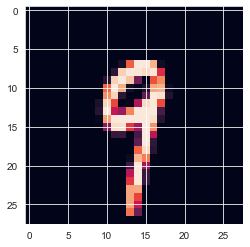

In [10]:
print(trainb[600])
plt.imshow(traina[600, :-1].reshape((28,28)))
plt.show()

In [11]:
class Optimizer():
    def __init__(self, cost, grad):
        self.cost = cost
        self.grad = grad
        
    def _log(self, array, x, a, b):
        err = ((a@x > 0).astype(int) * 2 - 1 != b).mean()
        array.append(err)
        return array
        
def hinge(x, a, b, lamb):
    hinge = 1 - a@x * b
    hinge[hinge < 0] = 0
    return  hinge.mean() + lamb * 0.5 * x@x


def grad_hinge(x, a, b, lamb):
    grad = - a * np.expand_dims(b, 1) 
    zero_values = (a@x * b) > 1
    grad[zero_values] = 0
    return grad.mean(0) + lamb * x

In [12]:
class GradientDescent(Optimizer):
    def __init__(self, cost, grad, proj=None):
        super().__init__(cost, grad)
        self.proj = proj if proj else lambda x : x
        
    def run(self, T, a, b, test, lamb, seed=0):
        np.random.seed(seed)
        testa, testb = test
        x = np.zeros(a.shape[1])
        costs = []
        errors = []
        for t in range(T):
            eta = 1 / (lamb * (t+1))
            cost = self.cost(x, a, b, lamb)
            grad = self.grad(x, a, b, lamb)
            y = x - eta * grad
            x = self.proj(y)
            costs.append(cost)
            err = ((testa@x > 0).astype(int) * 2 - 1 != testb).mean()
            errors.append(err)      
            
        return x, np.array(costs), np.array(errors)

In [13]:
def weighted_simplex_proj(x, D):
    

    """
    x, S: array (d,)
    """
    weighted_x = S * x
    rank = np.flip(np.argsort(weighted_x))
    x_sorted = x[rank]
    weight_sorted = S[rank]
    weighted_x_sorted = weighted_x[rank]

    values = (np.cumsum(x_sorted) - 1) / np.cumsum(1/weight_sorted)
    d = 0
    for d_i, Dx_i in enumerate(weighted_x_sorted):
        if Dx_i - values[d_i] < 0:
            d = d_i - 1
            break
    theta = values[d]
    proj = weighted_x - theta
    proj[proj < 0] = 0
    proj = proj / S
    return proj

def weighted_l1_ball_proj(x, D, z=1):
    if np.linalg.norm(x, ord=1) <= z:
        return x
    sign_x = (x >= 0).astype(int) * 2 - 1
    w = np.abs(x) / z
    w_proj = weighted_simplex_proj(w, D)
    proj = sign_x * z * w_proj
    return proj

In [14]:
### METAGRAD SVM

In [15]:


def MetaSlave(eta,w,Sigma,g, gg):
      
    Sigma = Sigma - 2*eta**2 * (Sigma@gg@Sigma) / (1 + g@Sigma@g)
    y = w - (eta * Sigma@g) / (1 + 2*eta**2 * g[None, :]@Sigma@g[:,None])
    w = weighted_l1_ball_proj(y, Sigma, 100)
    return([eta,w[0],Sigma])

In [16]:
def sommepond(L,w):
    a=0
    b=0
    for k in range(len(L)):
        a = a + L[k][0] * w[k] * L[k][1]

        b = b + (L[k][0] * w[k])
    return a/b

def surrogate(u,eta,x,g,gg):
    return(-eta*(x-u)@g + eta**2 *(x-u)@gg@(x-u))



def expsurrogate(x,w,L,t,g,M,alpha =0.01):
    a = 0
    for k in range(len(L)):
        a = a + w[k] * np.exp(surrogate(L[k][1],L[k][0],x,g,M))
        
    return np.exp(surrogate(L[t][1],L[t][0],x,g,M)) / a
    
    


In [17]:
class MetaGrad(GradientDescent):
    def run(self, T, a, b, test,lamb, z=100, G = 80,seed=0):
        np.random.seed(seed)
        testa, testb = test

        d = a.shape[1]
        x = np.zeros(d)
        w = np.ones(2*d) / (2*d)
        theta = np.zeros(2*d)
        
        costs = []
        errors = []
        x_iter = []
        #Init: sample elements
        
        n_slaves = int(math.log(T,2)/2)
        print(r'number of slaves : {n_slaves}')
        l_slaves = [2**(-k) /(5*z*G) for k in range(n_slaves)]
        weights = [((1+1/float(n_slaves))/((k+1)*(k+2))) for k in range(n_slaves)]
        L_slaves = [[2**(-k) /(5*z*G),np.zeros(d),z**2 *np.eye(d)] for k in range(n_slaves)]
        print(n_slaves)
        
        # First Log
        errors = self._log(errors, x, testa, testb)
        
        
        for t in range(T):
            #predict:
            x = sommepond(L_slaves,weights)
            
            
            #observe gradient:
            cost = self.cost(x,a,b,lamb)
            grad = self.grad(x,a,b,lamb)
            
            if t%10 ==0:
                print(cost)
            
            
            gg = grad[:, None]@grad[None, :] #"Mt"
            
            #update future weights:
            L = []
            for j in range(n_slaves):
                L.append(expsurrogate(x,weights,L_slaves,j,grad,gg))

                
            weights = L
                
            #Update our metamaster:
            for k in range(n_slaves):
                L_slaves[k] = MetaSlave(L_slaves[k][0],L_slaves[k][1],L_slaves[k][2],grad,gg)
    
                
            x_iter.append(x)
            costs.append(cost)
            
            #Monitor error with the averaged x_t
            errors = self._log(errors, np.stack(x_iter, 0).mean(0), testa, testb)      
            
        return np.stack(x_iter, 0).mean(0), np.array(costs), np.array(errors)
    
    

In [18]:
NUM_ITER = 140
BALL_RADIUS = 100

mgd = MetaGrad(cost=hinge, grad=grad_hinge, proj=weighted_l1_ball_proj)
start = time.time()
x, costs_mtg, errors_mtg = mgd.run(NUM_ITER, traina, trainb, lamb=1/3, G=100, z=BALL_RADIUS, test=(testa, testb))
stop = time.time()
print(f"Done {NUM_ITER} iterations in {(stop-start)/60 :.2} minutes.")

number of slaves : {n_slaves}
3
1.0
190.9827857838405
275.44671238135254
72.14729942487823
533.1131685478297
100.44525563029002
29.834910793695865
5980.162129331011
220.67041749814956
63.681555616921486
1087.748387616638
1292.7543205789343
4987.9821625344575
85830.68993900278
Done 140 iterations in 1.2 minutes.


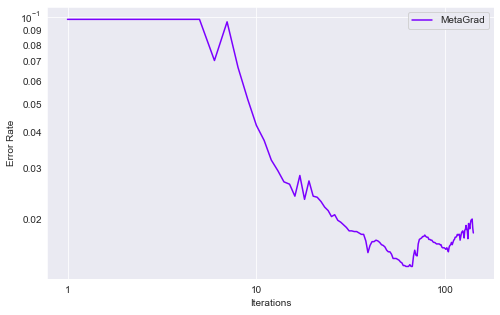

In [21]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(range(1,142), errors_mtg, label="MetaGrad")
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.set(xlabel="Iterations", ylabel="Error Rate")
plt.show()

In [28]:
NUM_ITER = 10000
BALL_RADIUS = 100

mgd = MetaGrad(cost=hinge, grad=grad_hinge, proj=weighted_l1_ball_proj)
start = time.time()
x, costs_mtg, errors_mtg = mgd.run(NUM_ITER, traina, trainb, lamb=1/3, G=600, z=BALL_RADIUS, test=(testa, testb))
stop = time.time()
print(f"Done {NUM_ITER} iterations in {(stop-start)/60 :.2} minutes.")

number of slaves : {n_slaves}
6
1.0
93.32208042881952
58.99670753521012
41.289692254563136
30.73607957929145
23.668466482367066
18.524784034732175
14.582056355814805
11.548320474920494
9.15241132276567
7.248814393116237
15.831576203310963
32.995817552731154
20.82453841889741
15.223472913218417
11.603969726634526
9.042327966297874
7.122701976290662
6.450467784996695
20.91236985235892
12.252939968703462
8.935938559978103
6.836879442095522
5.352973328395007
48.29648790178685
60.089062671643944
37.77964861439259
27.092830026915202
20.544848560708743
15.957548805155547
12.57102628095566
9.979953529652686
7.958722945645162
6.7260835133528065
1054.6040847314437
68.79778667372489
47.5075316160456
35.40966184825109
27.437542149295826
21.641341985728168
17.273611257687435
13.868365643515183
11.172099979343962
8.989093736328766
7.340203238799896
25.030165381188624
71.55265327427034
46.43151982874965
33.60701420979862
25.726264414351846
20.152279372242855
16.00654305780599
12.808405996172002
10.29

32.49071050179101
17.9919384020788
12.617832334630043
9.44424406652368
7.2740163262612345
5.704732281767381
4.498355510941645
4.247014426718989
91.05672539914306
54.19341753555159
37.16010642450197
27.593019815955284
21.210235421992394
16.612369792413695
13.150941865603347
10.475730335306086
8.35830570083748
6.674367295532068
5.344341432359684
4.246655705311905
7.6685829508495065
95.77600758676067
61.391738432076636
43.554215056962775
32.82857253429003
25.51824136968008
20.161937195786912
16.064308390315063
12.879024314176675
10.34459713328874
8.29320276800571
6.658992881351945
5.33917280285292
4.284660579830117
126.62960923618412
81.31963468626182
51.67280524591648
36.66153092296089
27.681872095571556
21.46207328776382
16.92213416546729
13.453427487818747
10.753606018829384
8.602288358716905
6.886792639964301
5.516425396043434
4.4012011718006905
3.7930921924126726
128.76335776101652
13.513169866256106
9.370650888869065
6.963054540764991
5.343688214102641
4.156967660547718
3.2465903954

8.942256747407363
7.095164985314615
5.660152173928774
5.288341515677117
520.1705247876087
53.73837177656182
33.929701950864036
24.487771796522736
18.586527275593475
14.431931530884363
11.372875942505983
9.02617463869889
7.1857325531150344
5.741205166527031
4.718143327578188
25.175780441668124
76.47671217200231
45.13671011788807
31.491691962131515
23.595697102527684
18.18350842146924
14.259542604209251
11.294732808408966
8.999599375396922
7.175255889381879
5.764197574940009
4.796112002938182
24.89967885972648
75.55493739134931
47.54206916724624
33.951566535040584
25.709525284280573
19.93496600479053
15.704575241169392
12.487076131893055
9.976610692128085
7.973541455701902
6.420043867678759
5.659057084499631
309.8035078375943
58.46623834919754
29.53456580341951
21.41826550027323
16.261437207736037
12.637557241321797
9.942677865192369
7.889843855811012
6.275520995697472
5.274013251475942
118.9348602667325
65.96984379550547
37.67859295597786
26.790165888582955
20.26385343562391
15.70660648

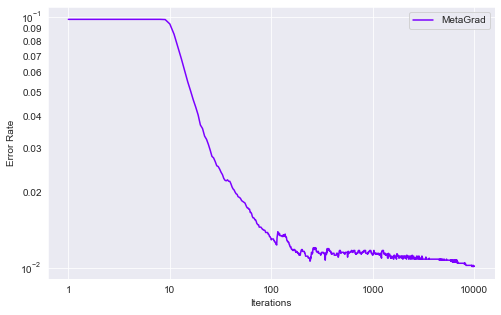

In [29]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(range(1,10002), errors_mtg, label="MetaGrad")
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.set(xlabel="Iterations", ylabel="Error Rate")
plt.show()

In [56]:
df.to_pickle(r"C:\\Users\\jacqu\\data\\MetaGrad.csv")

In [57]:
df.to_csv(r"C:\\Users\\jacqu\\data\\MetaGrad10000.csv")

2) 